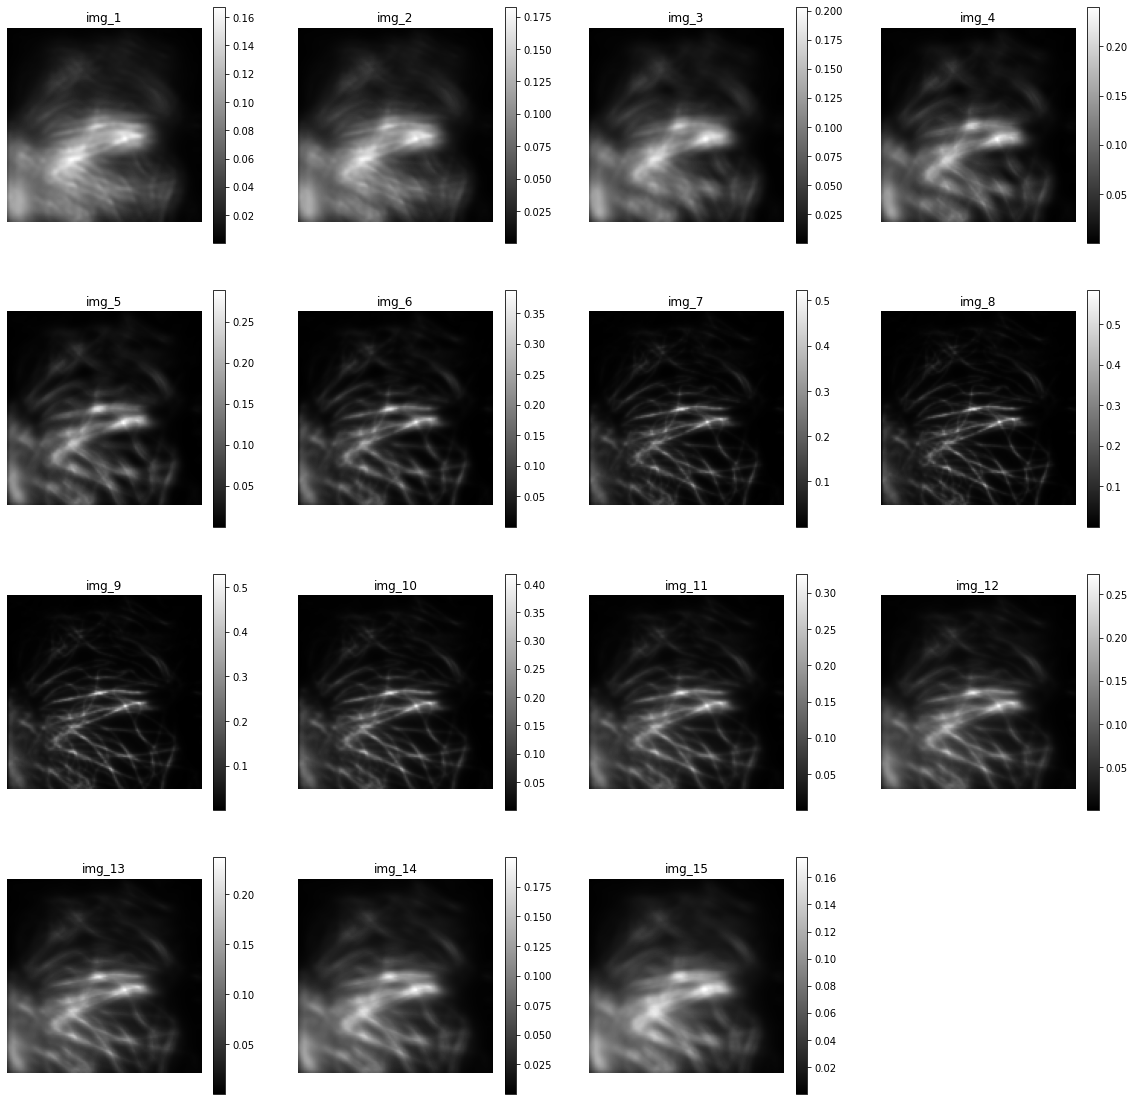

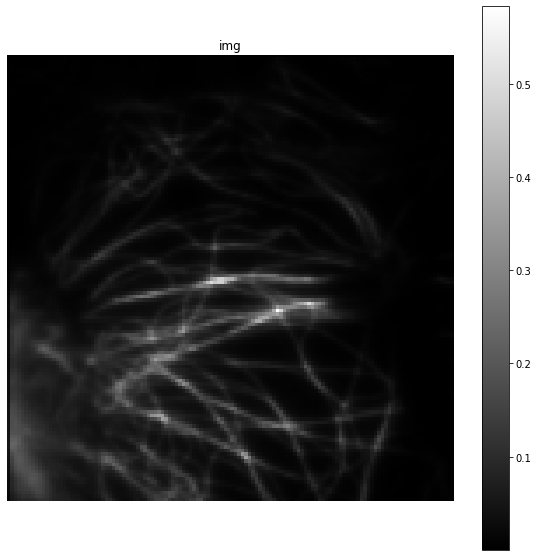

In [3]:
import numpy as np
import sys
import torch
import matplotlib.pyplot as plot

def show_tensor(tensor_img, scale=5, colormap="gray"):
    if (tensor_img.dtype == torch.complex128) | (tensor_img.dtype == torch.complex64):
        tensor_img = tensor_img.abs()
    if len(tensor_img.shape) == 3:
        sizes = torch.tensor(tensor_img.shape[0]).sqrt().ceil()
        plot.figure(figsize=(scale*sizes, scale*sizes))
        for idx, img in enumerate(tensor_img):
            plot.subplot(int(sizes), int(sizes), idx+1)
            plot.imshow(img, cmap=colormap)
            plot.axis("off")
            plot.title(f'img_{idx+1}')
            plot.colorbar()
        plot.show() 
    elif len(tensor_img.shape) == 2:
        sizes = 2*scale
        plot.figure(figsize=(sizes, sizes))
        plot.imshow(tensor_img, cmap=colormap)
        plot.axis("off")
        plot.title(f'img')
        plot.colorbar()
        plot.show()
    else:
        print("无法展示该形状的张量")
        sys.exit()

path = "/Volumes/昊大侠/工作/上海理工大学/论文/小论文/超分辨成像/数据集/data_label/0517/Psf_data/Microtubules/psf_obj_-0.1218_13_1.npy"
psf_3d = np.load(path)
psf_3d = torch.tensor(psf_3d)
show_tensor(psf_3d)
show_tensor(psf_3d[7])

# 伪点扩散函数 *Pseudo PSF*
- 像的强度谱 $I_i$
$$
\begin{aligned}
\text{非相干: }\mathcal{F}\{I_i\}&=(H\ast H)(G_o\ast G_o)\\
\Rightarrow I_i&=|h|^2\ast\ |U_o|^2\\
\text{相干: }\mathcal{F}\{I_i\}&=(HG_o)\ast(HG_o)\\
\Rightarrow I_i&=|h \ast U_o|^2
\end{aligned}
$$
- 通过对称的离焦面强度图计算 $\mathrm{PSF_{pseudo}}$
$$
\begin{aligned}
\mathrm{plane_1}
&=object\ast PSF_1\\
\mathrm{plane_{-1}}
&=object\ast PSF_{-1}\\
\mathrm{PSF_{pseudo}} 
&= \mathcal{F}^{-1}\left\{ \frac{\mathcal{F}\{ \mathrm{plane_1} \}}{\mathcal{F}\{ \mathrm{plane_{-1}} \}} \right\}\\
&= \mathcal{F}^{-1}\left\{ \frac{\mathcal{F}\{ object\ast PSF_1 \}}{\mathcal{F}\{ object\ast PSF_{-1} \}} \right\}\\
&= \mathcal{F}^{-1}\left\{ \frac{\mathcal{F}\{ object \}\cdot \mathcal{F}\{ PSF_1 \}}{\mathcal{F}\{ object \}\cdot \mathcal{F}\{ PSF_{-1} \}} \right\}\\
&= \mathcal{F}^{-1}\left\{ \frac{\mathcal{F}\{ PSF_1 \}}{\mathcal{F}\{ PSF_{-1} \}} \right\}
\end{aligned}
$$

In [20]:
def compute_psf(tensor_img):
    pairs = tensor_img.shape[0] // 2
    psf_pseudo_group = []
    for idx in range(pairs):
        plane1 = tensor_img[pairs+idx]
        plane2 = tensor_img[pairs-idx]
        psf_pseudo = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.fft2(plane1)/torch.fft.fft2(plane2)))
        psf_pseudo_group.append(psf_pseudo)
    psf_pseudo_group = torch.stack(psf_pseudo_group, )

    return psf_pseudo_group

def crop_tensor(inputs, scale=2):
    h, w = inputs.shape[-2:]
    outputs = inputs[:, h//2-h//(2*scale):h//2+h//(2*scale)+1, w//2-w//(2*scale):w//2+w//(2*scale)+1]
    
    return outputs

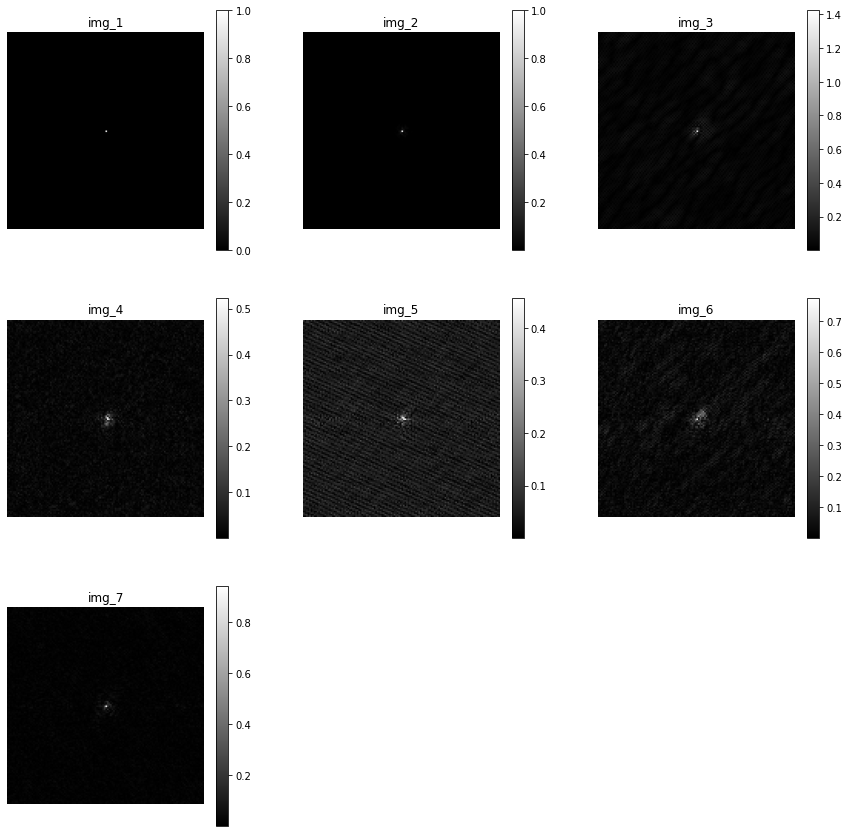

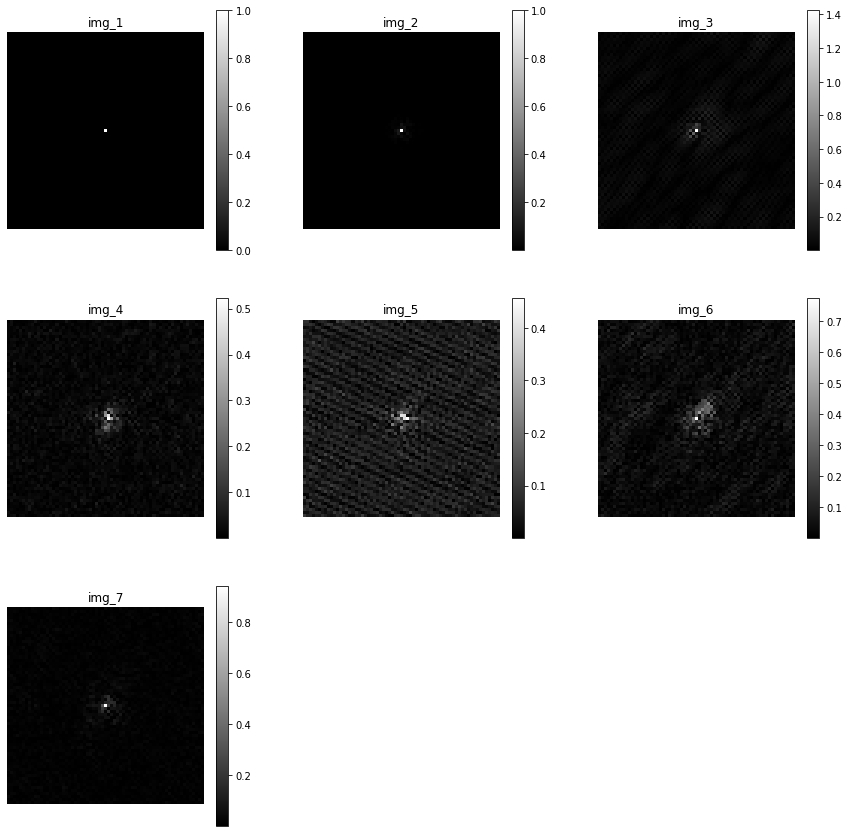

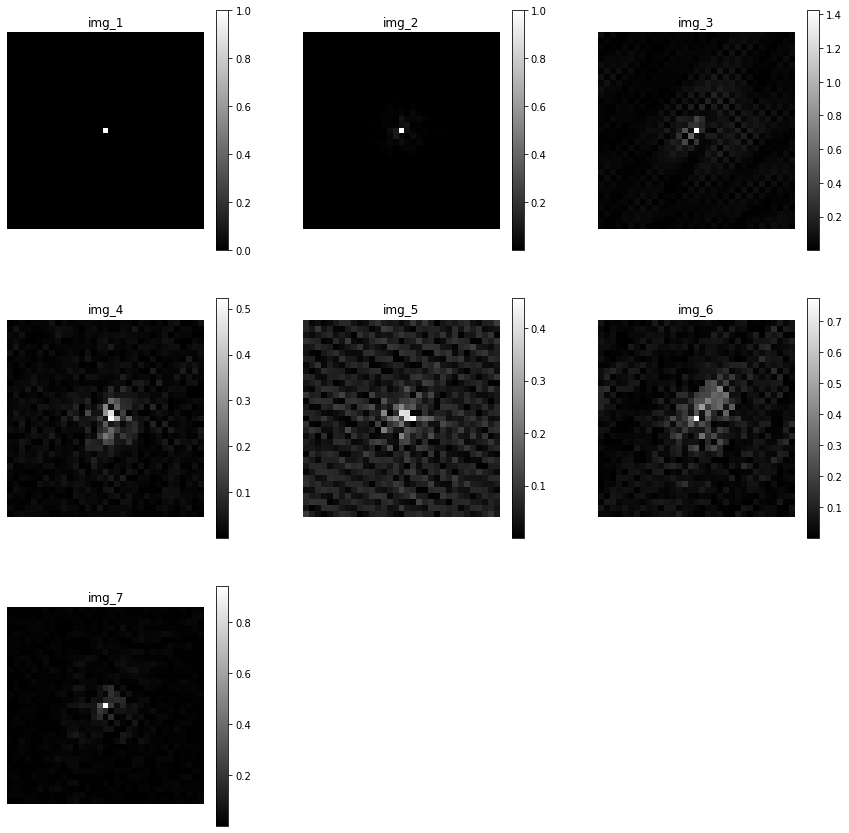

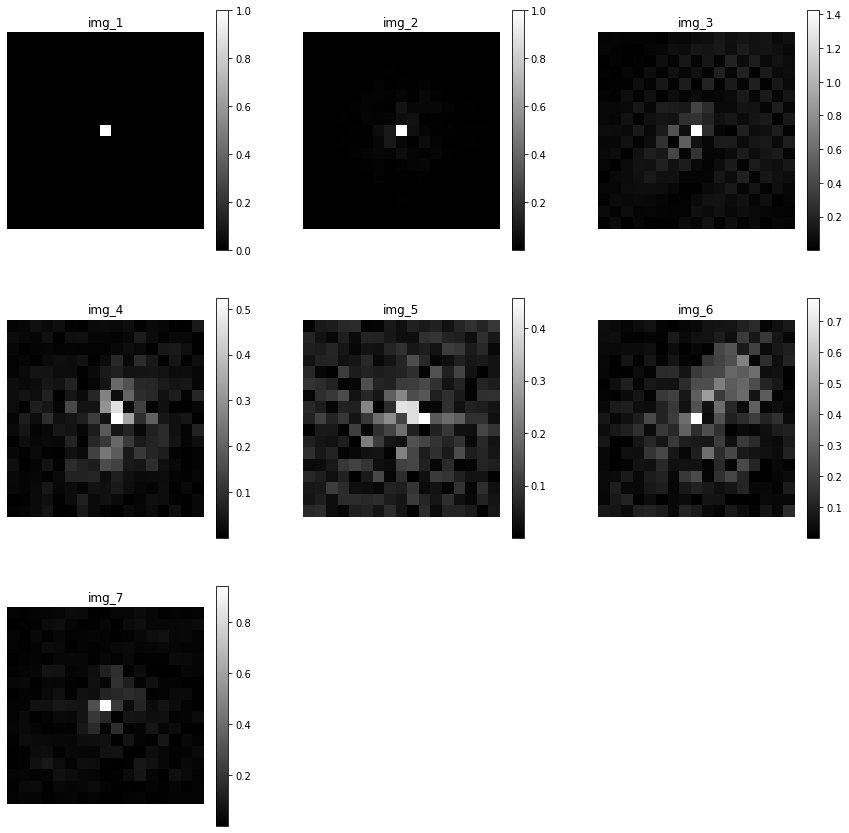

In [25]:
show_tensor(compute_psf(psf_3d))
show_tensor(crop_tensor(compute_psf(psf_3d), scale=2))
show_tensor(crop_tensor(compute_psf(psf_3d), scale=4))
show_tensor(crop_tensor(compute_psf(psf_3d), scale=8))

In [6]:
dname = psf_3d.dtype
dname == torch.float64

True